In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['cell_images']


In [32]:
import tensorflow as tf
tf.enable_eager_execution()
is_correct_version = '1.13.' in tf.__version__
assert is_correct_version , "Wrong Tensorflow Version [{}]".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled, "Eager mode not activated"

In [33]:
import pathlib
data_root = pathlib.Path("../input/cell_images/cell_images")
print(data_root)
for item in data_root.iterdir():
  print(item)

../input/cell_images/cell_images
../input/cell_images/cell_images/Uninfected
../input/cell_images/cell_images/Parasitized


In [34]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

27560

In [35]:
all_image_paths[:10]

['../input/cell_images/cell_images/Uninfected/C232ThinF_IMG_20151112_154424_cell_42.png',
 '../input/cell_images/cell_images/Parasitized/C128P89ThinF_IMG_20151004_130810_cell_157.png',
 '../input/cell_images/cell_images/Uninfected/C88P49ThinF_IMG_20150820_151451_cell_99.png',
 '../input/cell_images/cell_images/Parasitized/C80P41ThinF_IMG_20150817_111246_cell_114.png',
 '../input/cell_images/cell_images/Parasitized/C37BP2_thinF_IMG_20150620_133111a_cell_88.png',
 '../input/cell_images/cell_images/Uninfected/C131P92ThinF_IMG_20151004_145410_cell_93.png',
 '../input/cell_images/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134625_cell_8.png',
 '../input/cell_images/cell_images/Uninfected/C1_thinF_IMG_20150604_105100_cell_213.png',
 '../input/cell_images/cell_images/Uninfected/C60P21thinF_IMG_20150804_113602_cell_22.png',
 '../input/cell_images/cell_images/Parasitized/C97P58ThinF_IMG_20150917_152032_cell_157.png']

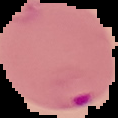

C119P80ThinF_IMG_20151002_124425_cell_135


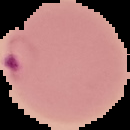

C97P58ThinF_IMG_20150917_145555_cell_171


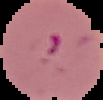

C136P97ThinF_IMG_20151005_143743_cell_118


In [36]:
import IPython.display as display

def caption_image(image_path):
    return image_path.split('/')[-1].split('.')[0]
    
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))

In [37]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Parasitized', 'Uninfected']

In [38]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Parasitized': 0, 'Uninfected': 1}

In [39]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]


In [40]:
img_path = all_image_paths[3]
img_path

'../input/cell_images/cell_images/Parasitized/C80P41ThinF_IMG_20150817_111246_cell_114.png'

In [41]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=33949, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0...


In [42]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(142, 181, 3)
<dtype: 'uint8'>


In [43]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.86050534


In [44]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize_images(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

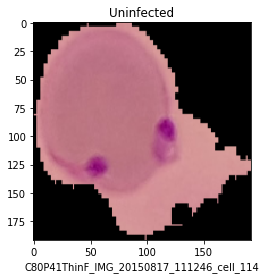

In [45]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

After inspecting the images, let's create the dataset iterator to use the dataset in the neural network.

In [46]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [47]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

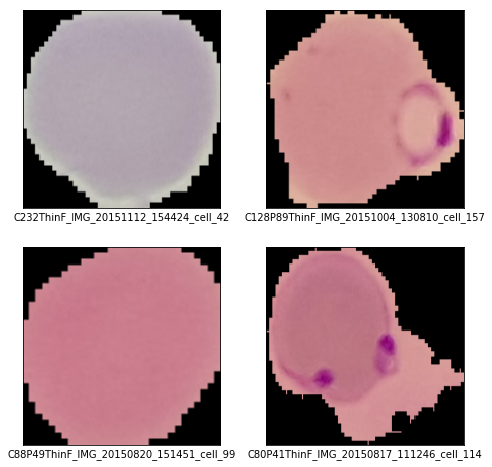

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [49]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [50]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Uninfected
Parasitized
Uninfected
Parasitized
Parasitized
Uninfected
Parasitized
Uninfected
Uninfected
Parasitized


In [51]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [52]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>